In [1]:
import gym
import random,math
import numpy
import pandas
from functools import reduce

In [2]:
env = gym.make('CartPole-v1')

In [3]:
class QLearningAgent:
    def __init__(self, actions, epsilon=0.1, gamma=0.90, alpha=0.01, **args):
        self.alpha = alpha # learning rate
        self.gamma = gamma # discount
        self.epsilon = epsilon # exploration probability
        self.actions = actions
        self.qs = {} # state table

    def getQValue(self, state, action):
        if not (state in self.qs) or not (action in self.qs[state]):
            return 0.0
        else:
            return self.qs[state][action]

    def getLegalActions(self,state):
        return self.actions

    # def getAction(self, state):
    #     action = None
    #     if util.flipCoin(self.epsilon):
    #         legalActions = self.getLegalActions(state)
    #         action = random.choice(legalActions)
    #     else:
    #         action = self.computeActionFromQValues(state)
    #     return action

    def getAction(self, state):
        """
          Compute the best action to take in a state.  Note that if there
          are no legal actions, which is the case at the terminal state,
          you should return None.
        """
        legalActions = self.getLegalActions(state)
        if len(legalActions) == 0:
            return None
        q = [self.getQValue(state, a) for a in legalActions]
        maxQ = max(q)

        # this is the trick.
        if random.random() < self.epsilon:
            minQ = min(q)
            mag = max(abs(minQ), abs(maxQ))
            q = [q[i] + random.random() * mag - 0.5 *mag for i in range(len(legalActions))]
            maxQ = max(q)

        count = q.count(maxQ)
        if count > 1:
            best = [i for i in range(len(legalActions)) if q[i] == maxQ]
            i = random.choice(best)
        else:
            i = q.index(maxQ)
        return legalActions[i]

    def update(self, state, action, nextState, reward):
        """
        Update q-value of the given state
        """
        if not (state in self.qs):
            self.qs[state] = {}
        if not (action in self.qs[state]):
            self.qs[state][action] = reward
        else:
            maxqnew = max([self.getQValue(nextState, a) for a in self.getLegalActions(nextState)])
            diff = reward + self.gamma * maxqnew - self.qs[state][action]
            newQ = self.qs[state][action] + self.alpha * diff
            self.qs[state][action] = newQ

        # print "(s, a, s', r) = [%3d (%3.1f, %3.1f), %d, %3d (%3.1f, %3.1f), %.1f]" % \
        #     (state, self.getQValue(state,0), self.getQValue(state, 1), action, \
        #      nextState, self.getQValue(nextState,0), self.getQValue(nextState, 1), \
        #      reward)


def build_state(features):
    return int("".join(map(lambda feature: str(int(feature)), features)))

def to_bin(value, bins):
    return numpy.digitize(x=[value], bins=bins)[0]


last100Scores = [0] * 100
last100ScoresIndex = 0
last100Filled = False

# Number of states is huge so in order to simplify the situation
# we discretize the space to: 10 ** number_of_features
n_bins = 8
n_bins_angle = 10
cart_position_bins = pandas.cut([-2.4, 2.4], bins=n_bins, retbins=True)[1][1:-1]
cart_velocity_bins = pandas.cut([-1, 1], bins=n_bins, retbins=True)[1][1:-1]
pole_angle_bins = pandas.cut([-2, 2], bins=n_bins_angle, retbins=True)[1][1:-1]
angle_rate_bins = pandas.cut([-3.5, 3.5], bins=n_bins_angle, retbins=True)[1][1:-1]

last_time_steps = numpy.ndarray(0)

agent = QLearningAgent(actions=range(env.action_space.n),
                       alpha=0.5, gamma=0.90, epsilon=0.1)
episode_scores = []
average_scores = []
average_window = 50

for i_episode in range(100):
    state, _ = env.reset()

    # if i_episode > 100:
    #     agent.epsilon = 0.01

    for t in range(350):
        # env.render()

        # choose an action
        stateId = build_state([to_bin(state[0], cart_position_bins),
                               to_bin(state[1], cart_velocity_bins),
                               to_bin(state[2], pole_angle_bins),
                               to_bin(state[3], angle_rate_bins)])
        action = agent.getAction(stateId)

        # perform the action
        state, reward, done, info, _ = env.step(action)
        nextStateId = build_state([to_bin(state[0], cart_position_bins),
                               to_bin(state[1], cart_velocity_bins),
                               to_bin(state[2], pole_angle_bins),
                               to_bin(state[3], angle_rate_bins)])

        if done == False:
            # update q-learning agent
            agent.update(stateId, action, nextStateId, reward)
        else:
            reward = -200.0
            agent.update(stateId, action, nextStateId, reward)
            last100Scores[last100ScoresIndex] = t
            last100ScoresIndex += 1
            if last100ScoresIndex >= 100:
                last100Filled = True
                last100ScoresIndex = 0
            if i_episode >= average_window - 1:
                average_score = sum(episode_scores[-average_window:])/average_window
                average_scores.append(average_score)
            if not last100Filled:
                print ("Episode ",i_episode," finished after {} timesteps".format(t+1))
            else:
                print ("Episode ",i_episode," finished after {} timesteps".format(t+1)," last 100 average: ",(sum(last100Scores)/len(last100Scores)))
            last_time_steps = numpy.append(last_time_steps, [int(t + 1)])
            episode_scores.append(t+1)
            break

l = last_time_steps.tolist()
l.sort()
print("Overall score: {:0.2f}".format(last_time_steps.mean()))
print("Best 100 score: {:0.2f}".format(reduce(lambda x, y: x + y, l[-100:]) / len(l[-100:])))

Episode  0  finished after 30 timesteps
Episode  1  finished after 15 timesteps
Episode  2  finished after 18 timesteps
Episode  3  finished after 41 timesteps
Episode  4  finished after 20 timesteps
Episode  5  finished after 13 timesteps
Episode  6  finished after 25 timesteps
Episode  7  finished after 37 timesteps
Episode  8  finished after 41 timesteps
Episode  9  finished after 22 timesteps
Episode  10  finished after 11 timesteps
Episode  11  finished after 50 timesteps
Episode  12  finished after 19 timesteps
Episode  13  finished after 9 timesteps
Episode  14  finished after 62 timesteps
Episode  15  finished after 94 timesteps
Episode  16  finished after 83 timesteps
Episode  17  finished after 41 timesteps
Episode  18  finished after 26 timesteps
Episode  19  finished after 28 timesteps
Episode  20  finished after 110 timesteps
Episode  21  finished after 68 timesteps
Episode  22  finished after 108 timesteps
Episode  23  finished after 21 timesteps
Episode  24  finished aft

In [4]:
import matplotlib.pyplot as plt

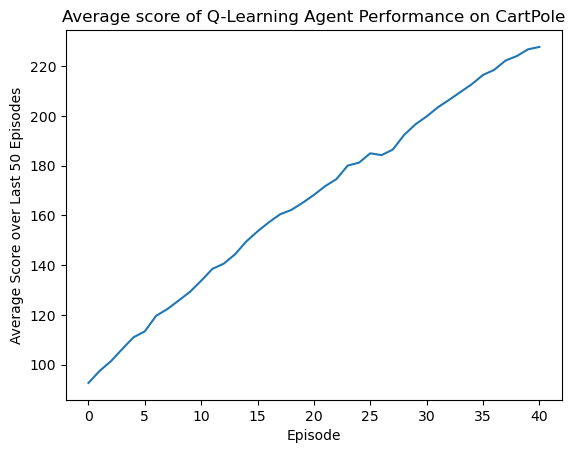

In [5]:
plt.plot(average_scores)
plt.xlabel('Episode')
plt.ylabel('Average Score over Last {} Episodes'.format(average_window))
plt.title('Average score of Q-Learning Agent Performance on CartPole')
plt.show()

Average score over 100 episodes: 145.10


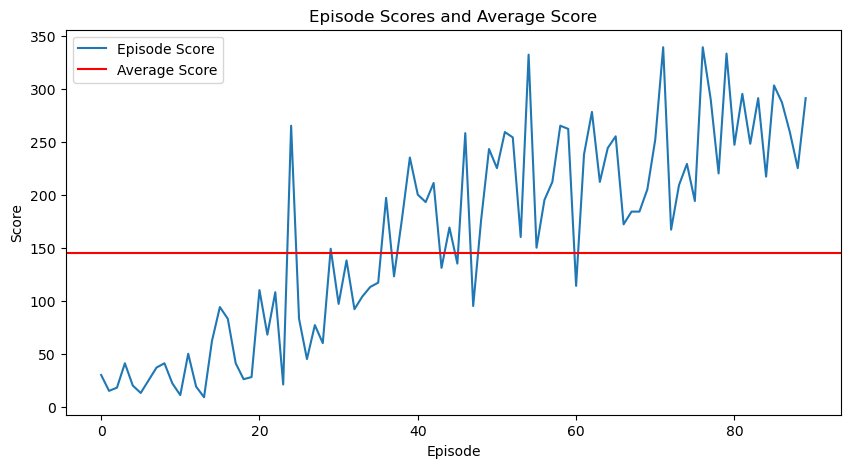

In [6]:
# Calculate average score
total_episodes = 100
average_score = sum(episode_scores) / total_episodes
print("Average score over {} episodes: {:.2f}".format(total_episodes, average_score))

# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(episode_scores, label='Episode Score')
plt.axhline(y=average_score, color='r', linestyle='-', label='Average Score')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Episode Scores and Average Score')
plt.legend()
plt.show()